In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import random
import numpy.random as rn

from sklearn.metrics import accuracy_score, log_loss
from scipy import optimize
from keras import losses
from keras import backend as K
import tensorflow as tf
from sklearn import neural_network

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier

import keras
from keras import losses
from functools import partial
import math
import random
import itertools

%matplotlib notebook

Using TensorFlow backend.


# Preprocessing

In [3]:
data = pd.read_csv('leaf.csv', header=None)
data.drop([1],inplace=True,axis=1)
X = data.values[:,1:]
Y_first = data.values[:,0]
Y = []
out = np.zeros(shape=[36])
for i in range(np.shape(Y_first)[0]):
    out[int(Y_first[i])-1]=1
    Y.append(out)
    out = np.zeros(shape=[36])
Y = np.array(Y)
# min_max_scaler = preprocessing.MinMaxScaler()
# X_scaled = min_max_scaler.fit_transform(X)
# df_normalized = pd.DataFrame(X_scaled)

r,c = np.shape(X)

total_samples = list(np.arange(0,r,1))
test_samples = random.sample(total_samples,int(np.round(len(total_samples)*0.2)))
train_samples = list(set(total_samples) - set(test_samples))

# Splitting Data

In [4]:
# trainX = X[train_samples]
# trainX_scaled = (trainX-np.min(trainX))/(np.max(trainX)-np.min(trainX))
# trainY = Y[train_samples]
# trainY_comp = Y_first[train_samples]

# testX = X[test_samples]
# testX_scaled = (testX-np.min(testX))/(np.max(testX)-np.min(testX))
# testY = Y[test_samples]
# testY_comp = Y_first[test_samples]
# print(len(trainX[0]))
# print(len(trainY[0]))

14
36


In [90]:
trainX = np.load('trainX.npy')
trainY = np.load('trainY.npy')
trainY_comp = np.load('trainY_comp.npy')

testX = np.load('testX.npy')
testY = np.load('testY.npy')
testY_comp = np.load('testY_comp.npy')

trainX_val= np.load('trainX_val.npy')
trainY_val=np.load('trainY_val.npy')
trainY_comp_val=np.load('trainY_comp_val.npy')

#  Neural Network

In [91]:
def nn_objective_train(x):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY * np.log(output))
    return er

def nn_objective_val(x):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX_val, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY_val * np.log(output))
    return er



# HC

In [112]:
def hillclimb(x,step_size,move_operator,objective_function,max_evaluations):
    '''
    hillclimb until either max_evaluations
    is reached or we are at a local optima
    '''
    best=np.copy(x)
    best_val = np.copy(x)
    
    best_score=objective_function(best[0])
    best_score_val = nn_objective_val(best_val[0])
    best_all = [best_score]
    best_all_val = [best_score_val]
    num_evaluations=1
    
    for i in range(max_evaluations):
        print(i)
#     while num_evaluations < max_evaluations:
        # examine moves around our current position
        move_made=False
        for next in move_operator(best,step_size):
#             if num_evaluations >= max_evaluations:
#                 break
            
            # see if this move is better than the current
            next_score=objective_function(next)
            next_score_val = nn_objective_val(next)
            num_evaluations+=1
            if next_score < best_score:
                best=np.array([next])
                best_score=next_score
                best_all.append(best_score)
                move_made=True
                if next_score_val < best_score_val:
                    best_val = np.array([next])
                    best_score_val = next_score_val
                    best_all_val.append(best_score_val)
                break # depth first search
            
        if not move_made:
            break # we couldn't find a better move 
                     # (must be at a local maximum)
    
    return (num_evaluations,best_score,best,best_score_val,best_val,best_all,best_all_val)

def move(x,step_size):
    b = np.transpose(np.concatenate((x-0.5,x,x+0.5)))
    b_i = []
    for i in range(np.shape(b)[0]):
        for j in range(2):
            if j == 0:
                b_t = np.copy(b[:,1])
                b_t[i] = b[i,0]
                b_i.append(np.transpose(b_t))
            else:
                b_t = np.copy(b[:,1])
                b_t[i] = b[i,2]
                b_i.append(np.transpose(b_t))
    return b_i   

# Step Size

In [102]:
num_inputs = 14
num_outputs = 36

hidden_layer_neurons = 405

weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
bias_all = hidden_layer_neurons+num_outputs

tw = weights_all+bias_all 
w0 = 2*np.random.random((1,tw))-2
x0 = np.array([[1,5,3]])

step_size = np.array([0.1,0.2,0.3,0.4,0.5])

train = []
val = []
for i in range(len(step_size)):
    num_evaluations,best_score,best,best_score_val,best = hillclimb(w0,step_size[i],move,nn_objective_train,100)
    train.append(best_score)
    val.append(best_score_val)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

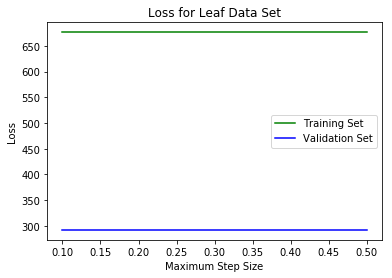

In [107]:
plt.plot(step_size,np.array(train),'g',label='Training Set')
plt.plot(step_size,np.array(val),'b',label='Validation Set')
plt.xlabel('Maximum Step Size')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')
plt.legend()
plt.show()

# Restarts

In [104]:
num_inputs = 14
num_outputs = 36

hidden_layer_neurons = 405

weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
bias_all = hidden_layer_neurons+num_outputs

tw = weights_all+bias_all 
w0 = 2*np.random.random((1,tw))-2
x0 = np.array([[1,5,3]])

restarts = np.array([1,2,3,4,5])

train_2 = []
val_2 = []

for i in range(len(restarts)):
    train_best = 0
    val_best = 0
    for j in range(restarts[i]):
        num_evaluations,best_score,best,best_score_val,best = hillclimb(w0,0.5,move,nn_objective_train,100)
        if j == 0:
            train_best = best_score
            val_best = best_score_val
        else:
            if best_score < train_best:
                train_best = best_score
                val_best = best_score_val       
    train_2.append(best_score)
    val_2.append(best_score_val)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

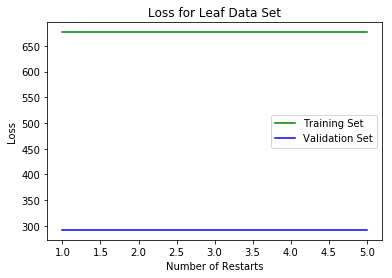

In [135]:
plt.plot(restarts,np.array(train),'g',label='Training Set')
plt.plot(restarts,np.array(val),'b',label='Validation Set')
plt.xlabel('Number of Restarts')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')
plt.legend()
plt.show()

# Grid Search

In [113]:
 num_evaluations,best_score,best,best_score_val,best_val,best_all,best_all_val = hillclimb(w0,0.5,move,nn_objective_train,100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


[[ 305.11955615  303.93940342  303.07889344  302.37939214  301.69652674
   301.10242629  300.89235615  299.63731613  299.11808209  299.02137126
   298.93700254  298.72770584  298.63511868  298.54889877  298.29949275
   298.25303124  297.86042465  297.71295071  297.41705625  297.31387712
   297.21867731  297.20362166  296.59763396  296.48867164  296.41746039
   296.06834859  295.32942442  294.68619136  294.14063371  293.4883748
   293.48668111  293.10547886  292.96461558  292.95388393  292.95330925
   292.94406026  292.8593441   292.63375894  292.44242075  292.30077566
   292.19990963  291.94031998  291.74672753  291.60021082  291.32441186
   291.12338044  291.121795    291.1066725   290.95942545  290.92826942
   290.64287995  290.52152003  290.49830062  290.24611435  290.03395112
   289.86662442  289.51988518  289.51988518  289.51988518  289.51988518
   289.51988518  289.51988518  289.51988518  289.51988518  289.51988518
   289.51988518  289.51988518  289.51988518  289.51988518  289.51

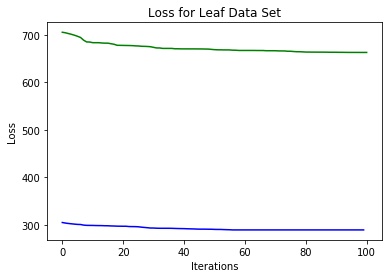

In [134]:
best_all_val_c = np.zeros((1,100))
best_all_val_c[0,0:57]=best_all_val
best_all_val_c[0,57:] = best_all_val[-1]
print(best_all_val_c)
plt.plot(best_all,'g',label='Training Set')
plt.plot(best_all_val_c[0],'b',label='Validation Set')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss for Leaf Data Set')

print(np.shape(best_all_val))

In [118]:
def nn_objective_train(x_u):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    x = x_u[0]
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY * np.log(output))
    predict_out = l2_act
    predict_out = predict_out.flatten()
    acc = 1-accuracy_score(trainY_comp,predict_out)
    print(acc)
    return er

def nn_objective_val(x_u):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    x = x_u[0]
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(trainX_val, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(trainY_val * np.log(output))
    predict_out = l2_act
    predict_out = predict_out.flatten()
    acc = 1-accuracy_score(trainY_comp_val,predict_out)
    print(acc)
    return er

def nn_objective_test(x_u):
    num_inputs = 14
    num_outputs = 36

    hidden_layer_neurons = 405
    x = x_u[0]
    weights_all = num_inputs*hidden_layer_neurons + hidden_layer_neurons*num_outputs
    bias_all = hidden_layer_neurons+num_outputs
    iw_size = num_inputs*hidden_layer_neurons
    nn_weights = x[:weights_all]
    bias_all = x[weights_all:]
    iw = nn_weights[0:iw_size]
    ow = nn_weights[iw_size:]
    b1 = bias_all[:hidden_layer_neurons]
    b2 = bias_all[hidden_layer_neurons:]
    w1 = np.reshape(iw,(num_inputs, hidden_layer_neurons))
    w2 = np.reshape(ow,(hidden_layer_neurons, num_outputs))
    l1 = np.maximum(np.dot(testX, w1)+b1, 0)
    x_i = np.dot(l1, w2)+b2
    l2 = np.array(np.exp(x_i)/ np.exp(x_i).sum(axis=1)[:,None])  
    l2_act = np.argmax(l2,axis=1)+1
    output = np.clip(l2, 1e-15, 1. - 1e-15)
    er= -np.sum(testY * np.log(output))
    predict_out = l2_act
    predict_out = predict_out.flatten()
    acc = 1-accuracy_score(testY_comp,predict_out)
    print(acc)
    return er

In [121]:
x = best_val
print(nn_objective_train(x))
print(nn_objective_val(x))
print(nn_objective_test(x))

0.9
664.15921499
0.90243902439
289.519885185
0.852941176471
238.418502874
